In [ ]:
!pip install tensorflow

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from keras import Model, layers
from keras.models import load_model, model_from_json
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization

In [ ]:
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    ModelCheckpoint
)

In [ ]:
print(tf.__version__)
print(tf.config.list_logical_devices('GPU'))

tf.test.is_gpu_available()

2.18.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


True

In [ ]:
data_path = '/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/EyeDiseaseDataset'

datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input
    )
# Train generator (80%)
train_generator = datagen.flow_from_directory(
    data_path,
    subset='training',
    batch_size=32,
    class_mode='categorical',
    target_size=(256, 256),
    shuffle=True,
    )
# Validation generator (20%)
validation_generator = datagen.flow_from_directory(
    data_path,
    subset='validation',
    shuffle=False,
    class_mode='categorical',
    batch_size=32,
    target_size=(256, 256)
    )

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy tên lớp
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

# Lấy số lượng mẫu trong từng tập
train_size = train_generator.samples
val_size = validation_generator.samples

# Vẽ biểu đồ
dataset_sizes = [train_size, val_size]
dataset_labels = ['Train', 'Validation']

plt.figure(figsize=(8, 6))
plt.bar(dataset_labels, dataset_sizes, color=['blue', 'orange'])
plt.title('Dataset Sizes')
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')

# Thêm nhãn số trên cột
for i, size in enumerate(dataset_sizes):
    plt.text(i, size + 20, str(size), ha='center', va='bottom')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Lấy tên lớp
class_names = list(train_generator.class_indices.keys())

def plot_class_distribution_pie(generator, generator_name):
    labels = generator.classes
    class_counts = np.bincount(labels)

    plt.figure(figsize=(8, 6))
    plt.pie(class_counts, labels=class_names,
            autopct='%1.1f%%', startangle=90,
            colors=plt.cm.Paired.colors[:len(class_names)])
    plt.title(f'Class Distribution in {generator_name} Set (Pie Chart)')
    plt.axis('equal')
    plt.show()

# Vẽ biểu đồ phân bố lớp
plot_class_distribution_pie(train_generator, 'Train')
plot_class_distribution_pie(validation_generator, 'Validation')

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(256, 256, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(4, activation='softmax')(x)
models = Model(inputs=base_model.input, outputs=predictions)
models.summary()

<ipython-input-14-cbd31db18483>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False,


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 2,881,796 (10.99 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_1/bestweight_1.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)
csv_logger_callback = CSVLogger(
    '/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_1/training_history_1.csv', append=True
)
models.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [ ]:
# Train the model
history = models.fit(
    x=train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, early_stopping_callback, csv_logger_callback]
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.7583 - loss: 0.6487 
Epoch 1: val_accuracy improved from -inf to 0.46375, saving model to /content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_1/bestweight_1.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 1930s 19s/step - accuracy: 0.7590 - loss: 0.6468 - val_accuracy: 0.4638 - val_loss: 6.1177
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9182 - loss: 0.2646
Epoch 2: val_accuracy did not improve from 0.46375
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 786ms/step - accuracy: 0.9182 - loss: 0.2648 - val_accuracy: 0.2500 - val_loss: 37.9439
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9505 - loss: 0.1725
Epoch 3: val_accuracy did not improve from 0.46375
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 786ms/step - accuracy: 0.9503 - loss: 0.1728 - val_accuracy: 0.4175 - val_loss: 16.5875
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9373 - loss: 0.1883
Epoch 4: val_accuracy did not improve from 0.46375
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 801ms/step - accuracy: 0.9373 - loss: 0.1882 - val_accuracy: 0.4125 - val_loss: 10.2424
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9636 - loss: 0.1218
Epoch 5: val

100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 809ms/step - accuracy: 0.9635 - loss: 0.1219 - val_accuracy: 0.6662 - val_loss: 6.4351
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9707 - loss: 0.0954
Epoch 6: val_accuracy did not improve from 0.66625
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 799ms/step - accuracy: 0.9706 - loss: 0.0958 - val_accuracy: 0.2713 - val_loss: 31.4325
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9574 - loss: 0.1304
Epoch 7: val_accuracy did not improve from 0.66625
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 802ms/step - accuracy: 0.9574 - loss: 0.1303 - val_accuracy: 0.2675 - val_loss: 42.1748
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.9711 - loss: 0.1015
Epoch 8: val_accuracy did not improve from 0.66625
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 807ms/step - accuracy: 0.9711 - loss: 0.1015 - val_accuracy: 0.5875 - val_loss: 9.0017
Epoch 9/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9665 - loss: 0.1010
Epoch 9: val_

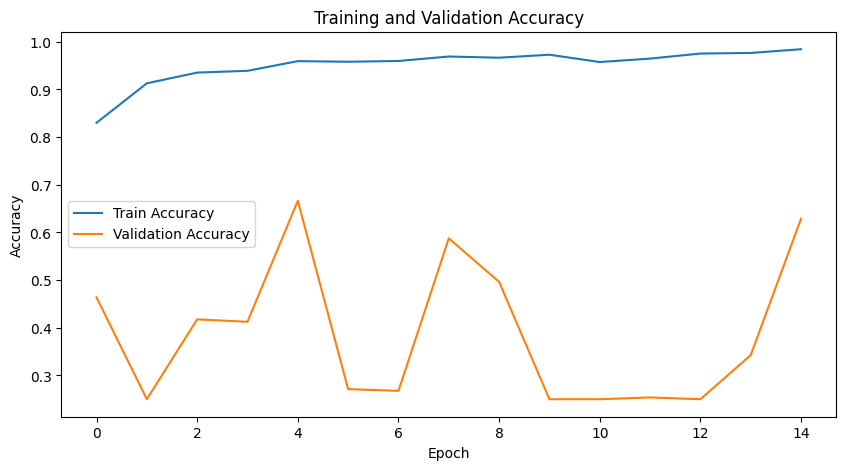

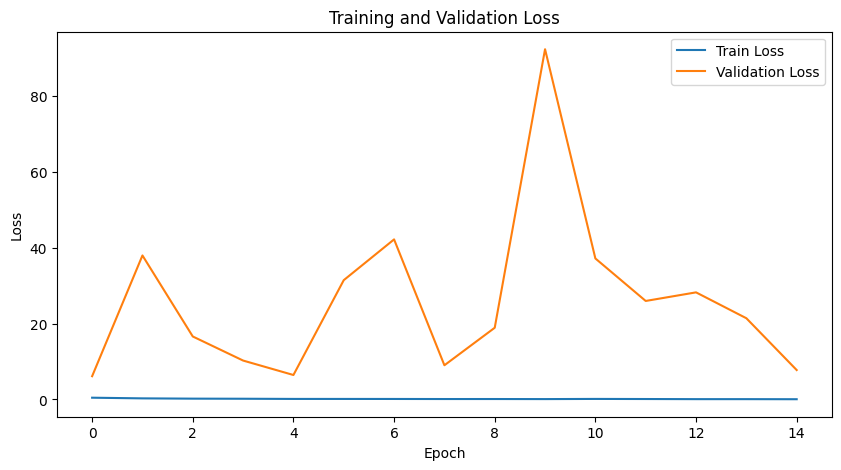

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.read_csv('/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_1/training_history_1.csv')

# Vẽ Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.savefig('/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_1/accuracy_plot.webp', format='webp')
plt.show()

# Vẽ Loss
plt.figure(figsize=(10, 5))
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss qua các Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('/content/drive/MyDrive/ChuyenDeChuyenSauTTNT2/my project/result_1/loss_plot.webp', format='webp')
plt.show()